In [1]:
from utils.decoders import VAE_Bayesian_MLP_decoder, simple_mlp_decoder
from utils.encoders import simple_mlp_encoder
from utils.mlp import create_nn_sequential_MLP,MLP
from utils.activations import get_activation
from utils.attention import MultiSelfAttention
from utils.priors import MogPrior, VampPrior, kl_divergence_two_gaussians,kl_divergence_gaussian_vs_mog,rho_to_logvar, var_to_rho
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math

def init_all(model, init_func, *params, **kwargs):
    for p in model.parameters():
        if p.requires_grad:
            #rand_int=torch.randint(-2,2,()).item()
            #rand_int=(torch.rand(1).item())*2-1
            #init_func(p, *params, **{k:v+rand_int for k,v in kwargs.items()})
            if p.ndim > 1:# Weight tensors
                init_func(p, *params, **kwargs)
            else: # Biases
                torch.nn.init.constant_(p,0.01)
            #p.data = torch.nn.functional.normalize(p,dim=-1).data
            #torch.nn.utils.weight_norm(p,name='weight',dim=1)

def sample_latent(mu, log_var):
    """
        Samples a latent vector via reparametrization trick
    """
    eps = torch.randn_like(mu, device=mu.device)
    z = torch.exp(0.5*log_var) * eps + mu
    return z
    
def kl_divergence_two_gaussians(mu0, logvar0, mu1, logvar1):
    return 0.5 * torch.sum(logvar1 - logvar0 - 1 + torch.exp(logvar0 - logvar1) + (mu0 - mu1).pow(2) * torch.exp(-logvar1), dim=1)

def get_beta(t):
    #return torch.nn.functional.sigmoid(t)
    return torch.nn.functional.softplus(t)

class VAE(torch.nn.Module):
    def __init__(self,vae_input_size,z_dim,enc_layers,activation_str,
                 vae_dropout_p, layernorm, skipconnections, skiptemperature, num_prior_components, prior_type, vae_prior_init_scaler,latent_moment_n_layers):
        super(VAE, self).__init__()
        self.num_prior_components = num_prior_components
    
        self.vae_encoder = MLP(vae_input_size, enc_layers,z_dim, get_activation(activation_str), 
                                         dropout_p=vae_dropout_p,layernorm=layernorm,skipconnections=skipconnections,skiptemperature=skiptemperature)
        
        self.vae_decoder = MLP(z_dim, enc_layers[::-1],vae_input_size, get_activation(activation_str), 
                                         dropout_p=vae_dropout_p,layernorm=layernorm,skipconnections=skipconnections,skiptemperature=skiptemperature)
        
        self.Prior = MogPrior(z_dim, self.num_prior_components, prior_type, init_scaler=vae_prior_init_scaler)
        beta_min = -8.

        self.thebeta = torch.nn.Parameter(torch.tensor(beta_min), requires_grad=True)

    def forward(self, batch, stochastic=True):
        z0 = self.vae_encoder(batch)
        z_soft = torch.nn.functional.softmax(z0/self.tau,dim=-1)
        
        if stochastic:
            z = torch.nn.functional.gumbel_softmax(z0, tau=self.tau, dim=-1)
        else:
            z = z_soft

        logits = self.vae_decoder(z)

        return logits, z,z_soft

In [2]:
from utils.GMVAE import GMVAENet

In [3]:
from sklearn.datasets import make_moons
import sys 


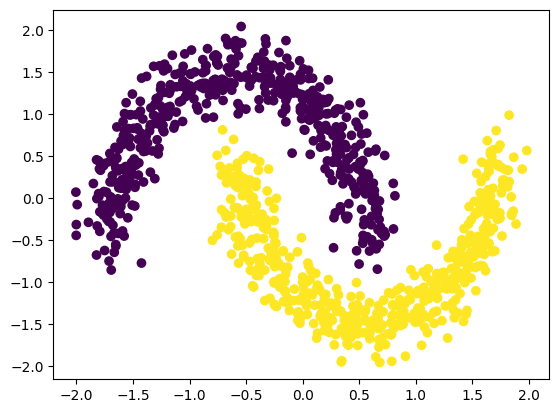

In [4]:

loss_func = torch.nn.MSELoss(reduction="none")
N = 1024
noise = 0.1
X, y = make_moons(n_samples=N, noise=noise, random_state=42)
X=torch.from_numpy(X).to(torch.float32)
mu = X.mean(0)
sigma = X.std(0)

X = (X - mu) / sigma

Xval, yval = make_moons(n_samples=N, noise=noise, random_state=42)

Xval = torch.from_numpy(Xval).to(torch.float32)
Xval = (Xval-mu)/sigma

fig, ax = plt.subplots()
ax.scatter(*Xval.detach().T,c=yval)

from torch.utils.data import DataLoader, Dataset

class TheDataset(Dataset):
    def __init__(self, X,y):
        self.X =X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
model = GMVAENet(2,2,2,h_dim=2)
out = model(X)
out.keys()
out["gaussian"].shape

torch.Size([1024, 2])

In [ ]:
vae_input_size = 2
z_dim = 2
enc_layers = [20]*3

prior_type = "mog_fixmeanfixvar"
# Prior_type = "mog_fixmean"

activation_str = "selu"
vae_activation = get_activation(activation_str)
vae_latent_activation = get_activation(activation_str)
vae_dropout_p = 0.01

layernorm = False
skipconnections = False
skiptemperature = False

d = vae_input_size
latent_moment_n_layers = None
num_prior_components = 2
vae_prior_init_scaler = .01

torch.manual_seed(0)
model = VAE(vae_input_size, z_dim, enc_layers, activation_str, 
            vae_dropout_p, layernorm, skipconnections,skiptemperature,
            num_prior_components, prior_type, vae_prior_init_scaler, latent_moment_n_layers)
model.tau = torch.nn.Parameter(torch.tensor([1.]), requires_grad=True)
Xpriors = []

lr = 1e-3

Loss = []
KL = []
MSE = []
Annealing = []
BETA = []
Var = []
MSE_val=[]
beta_min = 0.01
beta_max = 0.1
Tau = []
L = 1

optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)
n_epochs = 2500

epoch_beta_start = 1000                                            ####  n_epochs // 10
epoch_beta_end = 1500
found_nans = False

stochastic = True
batch_size = 32
training_loader = DataLoader(TheDataset(X, y), batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    epoch_loss = 0.
    epoch_mse = 0.

    for batch, ybatch in training_loader:
        
        optimizer.zero_grad()
        logits, z, z_soft = model.forward(batch, stochastic=stochastic)
        entropy = -(z_soft*(z_soft.log())).sum(1)

        mse_loss = loss_func(batch, logits).sum(1)
        loss = mse_loss + entropy # ((1+epoch)/n_epochs)*
        epoch_loss += loss.mean()#.item()
        epoch_mse += mse_loss.mean()#.item()
        
        if loss.mean().isnan():
            print("Loss", loss.isnan().any(), "MSE", mse_loss.isnan().any())
            found_nans = True
            break

        
        loss = loss.mean()
        loss.backward()
        optimizer.step()
    #with torch.no_grad():
        #Xhat_val,zval,_ = model.forward(Xval)

        #mse_loss_val = loss_func(Xval, Xhat_val).sum(1).mean().item()

    if found_nans:
        print("NANS")
        break
    Loss.append(epoch_loss.item()/len(training_loader))
    MSE.append(epoch_mse.item()/len(training_loader))
    MSE_val.append(mse_loss_val)
    Tau.append(model.tau.item())

fig, ax = plt.subplots()
ax.plot(Loss, label="Loss")
ax.plot(MSE_val, label="MSE_val")
ax.plot(MSE, label="MSE")
ax.set_yscale("log")
ax.legend()

with torch.no_grad():
    Xhat_val,zval,_ = model.forward(Xval)

fig, ax = plt.subplots()
ax.scatter(*z[ybatch==0].detach().T)
ax.scatter(*z[ybatch==1].detach().T)
ax.scatter(*zval[yval==0].detach().T, marker="x")
ax.scatter(*zval[yval==1].detach().T, marker="x")

fig, ax = plt.subplots()
ax.scatter(*X.detach().T, c="black")
ax.scatter(*logits.detach().T, c=ybatch)

fig, ax = plt.subplots()
ax.scatter(*Xval.detach().T, c="black")
ax.scatter(*Xhat_val.detach().T, c=yval)

#print("End tau:",model.tau)

fig, ax = plt.subplots()
ax.plot(Tau)

0.01
0.01


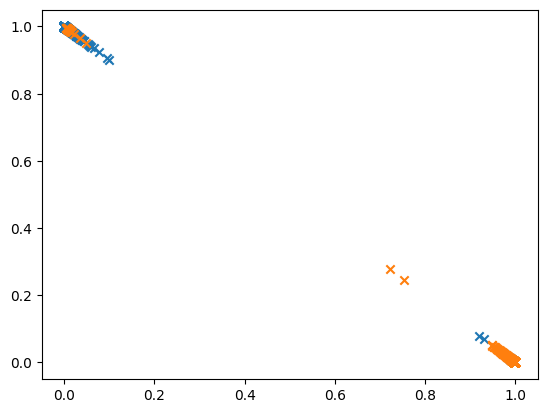

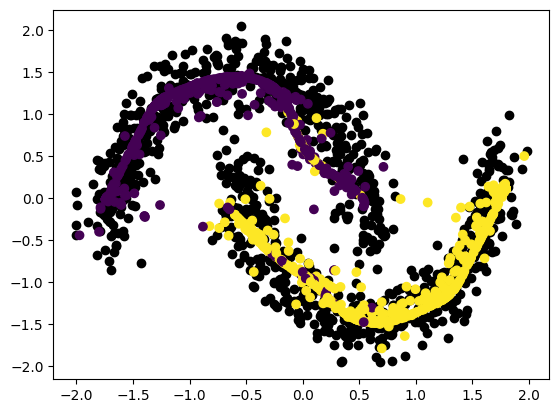

In [15]:
with torch.no_grad():
    model.tau[:]=9
    Xhat_val,zval,_ = model.forward(Xval, stochastic=True)
fig, ax = plt.subplots()
ax.scatter(*zval[yval==0].detach().T, marker="x")
ax.scatter(*zval[yval==1].detach().T, marker="x")

fig, ax = plt.subplots()
ax.scatter(*Xval.detach().T, c="black")
ax.scatter(*Xhat_val.detach().T, c=yval)


In [12]:
zval

tensor([[0.0888, 0.9112],
        [0.0286, 0.9714],
        [0.0011, 0.9989],
        ...,
        [0.9701, 0.0299],
        [0.0049, 0.9951],
        [0.1389, 0.8611]])